In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import shap


In [ ]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing

from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions
# os.listdir(r'C:\Users\hp\Desktop\dat\bloodpressure')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# ,force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Loading a sample .mat file to understand the data dimensions
test_sample =scipy.io.loadmat("/content/drive/MyDrive/Colab Notebooks/part_1.mat")['p']
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


In [ ]:
scalerX =  joblib.load("/content/drive/MyDrive/Colab Notebooks/patch/scalerX.pkl")
scalerY =  joblib.load("/content/drive/MyDrive/Colab Notebooks/patch/scalerY.pkl")

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# =============================
# Paramètres
# =============================
sample_size = 125  # taille de chaque segment (par ex. 1 seconde si 125 Hz)
signals = test_sample[0]  # tu peux remplacer par ton tableau de signaux

# =============================
# Segmentation des données
# =============================
ppg_segments = []
ecg_segments = []
bp_segments = []
sbp_values = []
dbp_values = []

for i in range(len(signals)):
    signal = signals[i]  # shape: (3, L)
    length = signal.shape[1]
    num_segments = length // sample_size

    for j in range(num_segments):
        start = j * sample_size
        end = (j + 1) * sample_size

        ppg_seg = signal[0, start:end]
        bp_seg = signal[1, start:end]
        ecg_seg = signal[2, start:end]

        sbp = np.max(bp_seg)
        dbp = np.min(bp_seg)

        # Append to lists
        ppg_segments.append(ppg_seg)
        bp_segments.append(bp_seg)
        ecg_segments.append(ecg_seg)
        sbp_values.append(sbp)
        dbp_values.append(dbp)

# =============================
# Conversion en tenseurs PyTorch
# =============================
X = torch.tensor(np.stack([ppg_segments, ecg_segments], axis=1), dtype=torch.float32)  # shape: (N, 2, 125)
y = torch.tensor(np.stack([sbp_values, dbp_values], axis=1), dtype=torch.float32)      # shape: (N, 2)

print(f"Input shape (X): {X.shape}")  # Ex: (256488, 2, 125)
print(f"Target shape (y): {y.shape}")  # Ex: (256488, 2)


Input shape (X): torch.Size([256488, 2, 125])
Target shape (y): torch.Size([256488, 2])


In [ ]:
X_scaled = scalerX.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
Y_scaled = scalerY.transform(y)
# X_scaled = scalerX.transform(X)

In [ ]:
class BloodPressureDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Création du DataLoader
dataset = BloodPressureDataset(X_scaled, Y_scaled)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# /*************  ✨ Windsurf Command ⭐  *************/
import torch.nn as nn

# /*************  ✨ Windsurf Command ⭐  *************/
import torch.nn as nn

class PatchTST(nn.Module):
    def __init__(self, input_channels=2, seq_len=125, patch_len=25, d_model=64, n_heads=4, num_layers=2, dropout=0.1):
        super(PatchTST, self).__init__()
        self.patch_len = patch_len
        self.seq_len = seq_len
        self.n_patches = seq_len // patch_len

        self.embedding = nn.Linear(input_channels * patch_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model * self.n_patches, 128)
        self.fc1 = nn.Linear(128, 2)

    def forward(self, x):
        # x: (batch_size, seq_len, input_channels)
        batch_size, seq_len, _ = x.size()
        x = x.view(batch_size, self.n_patches, -1)  # (batch_size, n_patches, input_channels * patch_len)
        x = self.embedding(x)  # (batch_size, n_patches, d_model)
        x = x.permute(1, 0, 2)  # (n_patches, batch_size, d_model)
        x = self.transformer(x)
        x = x.permute(1, 0, 2).contiguous().view(batch_size, -1)
        out = self.fc(x)
        out = self.fc1(out)
        return out

# /*******  69bce34e-5eab-4cec-847d-8feb669c802b  *******/

# /*******  69bce34e-5eab-4cec-847d-8feb669c802b  *******/

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

# ⚠️ Remplace ceci par ton vrai dataset et modèle
# from ton_module import dataset, PatchTST

# Suppose que tu as déjà un dataset complet
dataset_size = len(dataset)
val_size = int(0.2 * dataset_size)  # 20% pour la validation
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchTST().to(device)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/patch/PatchTSL_model_weights.pt'))


<All keys matched successfully>

In [ ]:
# Example: grab a few samples from the training dataloader
background_samples = []
for batch in train_loader:  # assuming your DataLoader is called train_loader
    inputs, _ = batch
    background_samples.append(inputs)
    if len(background_samples) >= 2:  # Take 2 batches, for example
        break

background = torch.cat(background_samples, dim=0)  # Concatenate into one tensor
background = background.to(next(model.parameters()).device)  # Move to same device as model


In [ ]:
# Example: grab a few samples from the test dataloader
test_samples = []
for batch in val_loader:  # assuming your test DataLoader is called test_loader
    inputs, _ = batch
    test_samples.append(inputs)
    if len(test_samples) >= 1:  # Take 1 batch, for example
        break

test_samples = torch.cat(test_samples, dim=0)
test_samples = test_samples.to(next(model.parameters()).device)


In [ ]:
background.shape

torch.Size([64, 2, 125])

In [ ]:
test_back = background.reshape(-1, background.shape[-1]).reshape(background.shape).to(device).float()

In [ ]:
test_test_samples = test_samples.to(device).float()

In [ ]:
test_test_samples.shape

torch.Size([32, 2, 125])

In [ ]:
# Explainability setup
explainer = shap.DeepExplainer(model, test_back)  # use a small sample for background
shap_values = explainer.shap_values(test_test_samples, check_additivity=False)     # explain on a few test samples


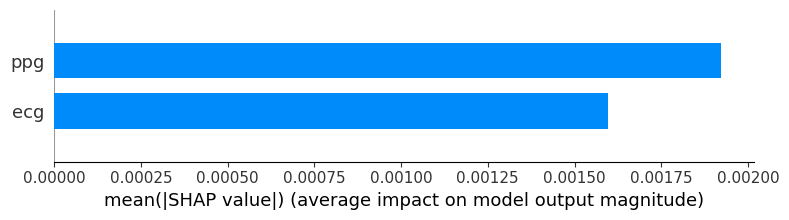

In [ ]:
feature_names = ['ppg','ecg']  # replace with your real feature names
# Moyenne sur les dimensions spatiales (2, 125)
mean_shap = shap_values.mean(axis=(1, 2))  # -> shape (32, 2)

shap.summary_plot(mean_shap, features=mean_shap, plot_type="bar", feature_names=feature_names)

# Plot summary of feature importances pour le moment hada el feature importance chnaamel bih lehne tchouf bih aham les features ... ama linna deja ma3andek kan zouz :/le aandi ppg w ecg w bp w eela nestaamlouhoch , elli fi el shema houma les features mta3 el X , est-ce que hadoukom houma ? le hedhoukom y
# shap.summary_plot(shap_values, test_test_samples, plot_type="bar", plot_size=(6, 3), feature_names=feature_names) howwa nafsou elli 3malnah min louel


Le graphe te montre quelle feature influence le plus les prédictions en général, pas juste pour un seul patient.

Si ppg > ecg, alors ton modèle s’appuie plus sur ppg que ecg globalement pour prédire SBP.

✅ Oui, les feature_names = ['ppg', 'ecg'] sont corrects ici car ce sont les deux canaux (features) que tu fournis au modèle. Les autres comme BP ne sont pas des features, ce sont des targets.



je prends la moyenne des SHAP values sur les dimensions spatiales (par canal et par temps), puis tu affiches un résumé global des importances des features (ppg et ecg).

➡️ Ceci est une interprétation GLOBALE.

In [ ]:

# Pick a single patient
patient_idx = 0  # for the first patient
patient_input = test_samples.to(device).float()
print(patient_input.shape)
# Compute SHAP values for just that one patient
single_shap_value = explainer.shap_values(patient_input, check_additivity=False)
print(single_shap_value[0].shape)

shap_values_for_class = single_shap_value[0][:, patient_idx]
print(shap_values_for_class.shape)
# Plot the force plot
# shap.initjs()

torch.Size([32, 2, 125])
(2, 125, 2)
(2, 2)


In [ ]:
# Pick a single patient (patient_idx = 0 pour le premier patient)
patient_idx = 0
patient_input = test_samples.to(device).float()

# Afficher la forme de l'entrée
print(patient_input.shape)  # (32, 2, 125)

# Calcul des valeurs SHAP pour ce seul patient
single_shap_value = explainer.shap_values(patient_input, check_additivity=False)

# Afficher la forme des valeurs SHAP
print(single_shap_value[0].shape)  # (2, 125, 2) - 2 classes, 125 features

# Extraire les valeurs SHAP pour le premier patient
# Pour chaque classe, tu dois extraire les valeurs SHAP pour chaque échantillon
shap_values_for_class = single_shap_value[0][:, :, patient_idx]  # (2, 125) - pour le premier patient

# Afficher la forme des valeurs SHAP
print(shap_values_for_class.shape)  # (2, 125) - 2 classes pour le patient spécifié

# S'assurer que la dimension des features et des shap_values correspond
patient_features = patient_input[patient_idx].cpu().numpy()
print(patient_features.shape)  # (2, 125) - 2 canaux et 125 échantillons

# Vérifier que les dimensions sont compatibles
assert shap_values_for_class.shape[1] == patient_features.shape[1], \
    f"Dimensions ne correspondent pas! {shap_values_for_class.shape[1]} != {patient_features.shape[1]}"

# Afficher le graphique de force
shap.initjs()

# Afficher le plot avec les valeurs SHAP pour le patient
shap.plots.force(
    explainer.expected_value[0],  # Valeur attendue pour la première classe (SBP)
    shap_values_for_class[0],  # Valeurs SHAP pour la première classe (SBP)
    features=patient_features[0],  # Caractéristiques du patient pour le premier canal
    feature_names=feature_names
)


torch.Size([32, 2, 125])
(2, 125, 2)
(2, 125)
(2, 125)


SHAP Locale (ex. patient_index=0, f(x)=0.07)
But : Expliquer la prédiction exacte faite pour un patient donné (ici f(x) = 0.07 pour SBP).

Résultat :

ppg = 0.5268

ecg = 0.4899

Interprétation :

Les deux signaux ont une contribution positive à la prédiction.

ppg a eu une influence un peu plus importante que ecg dans la prédiction de 0.07 pour SBP.

C’est une explication locale, propre à ce patient-là.



Explication détaillée :
f(x) = 0.07 pour SBP : C'est la prédiction du modèle pour la pression systolique (SBP) du patient. Le modèle a prédit une valeur de 0.07 pour SBP, basée sur les caractéristiques d'entrée (ECG et PPG).

ECG = 0.4899 : L'attribution pour le canal ECG est de 0.4899, ce qui signifie que le canal ECG a contribué positivement à la prédiction du modèle pour SBP. Le modèle a trouvé que les informations dans le signal ECG ont joué un rôle important dans la détermination de la prédiction de SBP pour ce patient.

PPG = 0.5268 : L'attribution pour le canal PPG est de 0.5268, indiquant que le signal PPG a également joué un rôle important, et sa contribution a été encore plus significative que celle de l'ECG pour cette prédiction.

🔹 Ici, je sélectionne un seul patient (i = 0) et tu affiches les SHAP values associées à cet échantillon, avec un force_plot pour visualiser comment chaque feature (temps et canal) a contribué à la prédiction.

➡️ Ceci est une interprétation LOCALE.

Ce code calcule les valeurs SHAP pour un patient spécifique, extrait les valeurs SHAP pour les classes et caractéristiques, et affiche un graphique de force pour visualiser l'impact de chaque caractéristique sur la prédiction du modèle. Cela permet d'interpréter comment chaque variable influence la prédiction du modèle pour un patient donné, ce qui est crucial dans des applications comme la médecine pour comprendre le comportement des modèles de machine learning.

In [ ]:
import joblib
import numpy as np

# Charger le scaler sauvegardé
scaler_x = joblib.load('/content/drive/MyDrive/Colab Notebooks/patch/scalerX.pkl')

# Exemple : 125 valeurs normalisées (remplace-les par tes vraies prédictions)
scaled_prediction_array = np.random.rand(1, 125)  # shape (1, 125)

# Inverser la mise à l’échelle
original = scaler_x.inverse_transform(scaled_prediction_array)

print(f"Prédiction inverse : {original}")


Prédiction inverse : [[1.54903625 1.41327384 1.54397215 1.2634725  1.56800426 1.01127783
  1.09181424 1.36434916 1.3055923  0.94538717 1.39488358 1.43187515
  1.64355237 1.41690485 1.02757677 1.20827926 1.13487503 1.80699711
  0.99967566 1.18673267 1.38944766 1.47603798 1.70914668 1.7359143
  1.89021068 1.48323487 1.54448453 1.17416258 1.69253421 1.63141523
  1.53998787 0.9247532  1.88419426 1.90846725 1.23110651 1.58166141
  1.8325043  1.58182731 1.71342757 1.79979277 1.04048972 1.14125639
  1.5930759  1.37896574 1.72680703 1.38162462 1.3958852  1.6141261
  1.26104384 1.57190929 1.0694642  1.36250049 1.5035015  1.58042296
  0.96883666 1.60887993 1.01237814 1.09762952 1.12464309 1.42686638
  1.27472116 1.56418951 1.5744801  1.50593488 1.23114595 1.20484404
  1.31940226 1.55774849 1.88378129 1.282644   1.15681648 1.37900929
  1.27973715 1.14139723 1.67528537 1.34843917 1.44443602 1.52142346
  1.84945299 1.64699461 1.604344   1.50296649 1.66725611 1.08000621
  1.36700544 1.37793325 1.402

In [ ]:
# shap.image_plot(shap_values)


In [ ]:
# Choisir un seul patient (ex: index 0)
i = 5
# Choisir une classe (ex: classe 0)
class_index = 0

# Extraire les SHAP values pour cet échantillon et cette classe
shap_values_single = shap_values[i, :, :, class_index]  # shape: (2, 125)

# Transformer en vecteur (option : flatten)
shap_values_flat = shap_values_single.flatten()

# Même chose pour les features
features_flat = patient_input[i].cpu().numpy().flatten()

# Créer des noms de features pour chaque valeur
# feature_names = [f"ch{c}_t{t}" for c in range(2) for t in range(125)]

# Affichage
shap.initjs()
shap.force_plot(
    explainer.expected_value[class_index],
    shap_values_flat,
    features_flat,
    feature_names=feature_names
)


In [ ]:
feature_names

['ppg', 'ecg']

In [ ]:
pip install captum


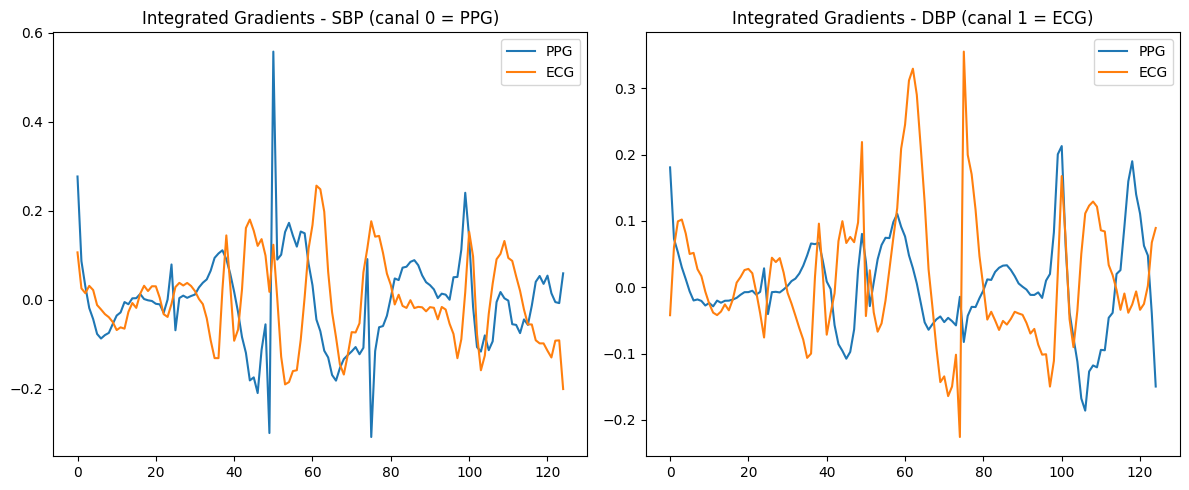

In [ ]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

model.eval()
ig = IntegratedGradients(model)

# Prenons un exemple du dataset
# Si ton échantillon est un numpy.ndarray, tu dois le convertir en tensor PyTorch
sample_X = torch.tensor(X_scaled[0], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 2, 125)
sample_y = y[0]

# Attribution pour la prédiction de SBP (index 0)
attr_sbp = ig.attribute(sample_X, target=0)

# Attribution pour DBP (index 1)
attr_dbp = ig.attribute(sample_X, target=1)

# Plot des attributions pour chaque canal (PPG et ECG)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Integrated Gradients - SBP (canal 0 = PPG)')
plt.plot(attr_sbp[0][0].cpu().detach().numpy(), label='PPG')
plt.plot(attr_sbp[0][1].cpu().detach().numpy(), label='ECG')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Integrated Gradients - DBP (canal 1 = ECG)')
plt.plot(attr_dbp[0][0].cpu().detach().numpy(), label='PPG')
plt.plot(attr_dbp[0][1].cpu().detach().numpy(), label='ECG')
plt.legend()
plt.tight_layout()
plt.show()


Si une attribution pour un point dans le signal PPG est très élevée, cela veut dire que le modèle a accordé une grande importance à cette période du signal PPG pour la prédiction de DBP.

Si une attribution pour un point dans le signal ECG est faible, cela indique que ce moment dans le signal ECG n'a pas eu beaucoup d'impact pour prédire DBP.



🧠 Qu'est-ce que "Integrated Gradients" ?
C’est une méthode d’explicabilité d’un modèle de deep learning. Elle permet de comprendre quelles parties du signal d’entrée ont le plus influencé la prédiction du modèle. Plus la valeur est élevée, plus cette partie du signal a eu de l'importance dans la décision.

🔍 Explication des deux graphiques :
1. Graphique de gauche :
Titre : Integrated Gradients - SBP (canal 0 = PPG)

SBP = Systolic Blood Pressure (Pression systolique)

On y observe les contributions du PPG (en bleu) et de l’ECG (en orange) à la prédiction de la pression systolique.

L’axe des ordonnées (vertical) représente l’importance du signal.

L’axe des abscisses (horizontal) est probablement le temps ou les points du signal.

➡️ Interprétation : Certaines portions du signal PPG et ECG ont des pics positifs ou négatifs indiquant qu'elles influencent fortement la prédiction de la pression systolique. Par exemple, autour du point 60, le PPG a une grande influence (pic bleu).

2. Graphique de droite :
Titre : Integrated Gradients - DBP (canal 1 = ECG)

DBP = Diastolic Blood Pressure (Pression diastolique)

Contribution du PPG (bleu) et ECG (orange) à la prédiction de la pression diastolique.

➡️ Interprétation : L’ECG semble jouer un rôle plus marqué ici, avec des pics d’importance plus nets autour des points 50–90. Cela signifie que ces segments du signal ECG ont fortement influencé la prédiction de la pression diastolique.

🎯 Résumé :
Ces graphiques montrent quelles portions des signaux PPG et ECG ont le plus influencé le modèle pour prédire la pression systolique (gauche) et diastolique (droite).

Les deux types de signaux ont une influence, mais l’importance varie selon le type de pression à prédire.

In [ ]:

from captum.attr import IntegratedGradients
import torch

# Initialisation du modèle et de l'IntegratedGradients
model.eval()
ig = IntegratedGradients(model)

# Exemple de l'échantillon à expliquer
sample_X = torch.tensor(X_scaled[0], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 2, 125)
sample_y = y[0]

# Attribution pour la prédiction de SBP (index 0)
attr_sbp = ig.attribute(sample_X, target=0)

# Attribution pour DBP (index 1)
attr_dbp = ig.attribute(sample_X, target=1)

# Extraction des valeurs des attributions
attr_sbp_ppg = attr_sbp[0][0].cpu().detach().numpy()
attr_sbp_ecg = attr_sbp[0][1].cpu().detach().numpy()

attr_dbp_ppg = attr_dbp[0][0].cpu().detach().numpy()
attr_dbp_ecg = attr_dbp[0][1].cpu().detach().numpy()

# Affichage des résultats en texte

print("--- Résultats des attributions pour SBP (pression systolique) ---")
print("Attribution pour PPG (canal 0) :")
print(f"Attributions de PPG : {attr_sbp_ppg[:5]}...")  # Affiche les premières valeurs pour la lisibilité
print("Attribution pour ECG (canal 1) :")
print(f"Attributions de ECG : {attr_sbp_ecg[:5]}...")  # Affiche les premières valeurs pour la lisibilité

print("\n--- Résultats des attributions pour DBP (pression diastolique) ---")
print("Attribution pour PPG (canal 0) :")
print(f"Attributions de PPG : {attr_dbp_ppg[:5]}...")  # Affiche les premières valeurs pour la lisibilité
print("Attribution pour ECG (canal 1) :")
print(f"Attributions de ECG : {attr_dbp_ecg[:5]}...")  # Affiche les premières valeurs pour la lisibilité


--- Résultats des attributions pour SBP (pression systolique) ---
Attribution pour PPG (canal 0) :
Attributions de PPG : [ 0.27670968  0.08659723  0.02979069 -0.01902266 -0.04393038]...
Attribution pour ECG (canal 1) :
Attributions de ECG : [0.10613016 0.02527058 0.01441771 0.03084478 0.02145206]...

--- Résultats des attributions pour DBP (pression diastolique) ---
Attribution pour PPG (canal 0) :
Attributions de PPG : [0.18080764 0.07304855 0.05279227 0.03006959 0.01238078]...
Attribution pour ECG (canal 1) :
Attributions de ECG : [-0.04211374  0.06076199  0.09942827  0.10217803  0.08119771]...


 Chaque valeur dans attr_sbp[0][0] correspond à un point dans le temps (parmi les 125) pour le canal PPG, et pareil pour ECG. En traçant la courbe, tu vois où (à quel timestamp) le modèle attribue le plus de poids à l’entrée pour faire sa prédiction SBP.


Résultats pour SBP (pression systolique) :
Attribution pour PPG (canal 0) :

Les valeurs d'attribution pour le canal PPG sont positives et varient légèrement autour de 0, indiquant que certaines portions du signal PPG ont contribué positivement à la prédiction de SBP. Par exemple, les premières valeurs sont 0.2767, 0.0866, 0.0298, etc. Cela signifie que le modèle a trouvé que certaines caractéristiques de PPG ont favorisé une prédiction plus élevée de la pression systolique.

Attribution pour ECG (canal 1) :

Les valeurs d'attribution pour le canal ECG sont également positives, mais plus faibles que celles de PPG. Par exemple, les premières valeurs sont 0.1061, 0.0253, 0.0144, etc. Cela suggère que les caractéristiques ECG ont contribué moins fortement à la prédiction du SBP comparé aux caractéristiques PPG.

Résultats pour DBP (pression diastolique) :
Attribution pour PPG (canal 0) :

Les attributions pour le canal PPG dans le cas de DBP sont positives, mais la contribution est plus faible que celle observée pour SBP. Par exemple, 0.1808, 0.0730, 0.0528, etc. Cela indique que le signal PPG a joué un rôle, mais avec une influence moins marquée sur la prédiction de DBP.

Attribution pour ECG (canal 1) :

Le canal ECG a une contribution plus forte pour DBP que pour SBP, avec des valeurs comme -0.0421, 0.0608, 0.0994, indiquant que certaines parties du signal ECG ont joué un rôle positif dans la prédiction de DBP.

Conclusion :
PPG semble avoir une influence plus significative sur la prédiction de la pression systolique (SBP) que pour la pression diastolique (DBP).

ECG a une influence plus forte sur DBP que sur SBP, ce qui peut suggérer que le modèle utilise principalement l'ECG pour estimer la pression diastolique.